In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/testset/TestDataSet/labels_list.json
/kaggle/input/testset/TestDataSet/n02769748/n02769748_10044.JPEG
/kaggle/input/testset/TestDataSet/n02769748/n02769748_10023.JPEG
/kaggle/input/testset/TestDataSet/n02769748/n02769748_10043.JPEG
/kaggle/input/testset/TestDataSet/n02769748/n02769748_100708.JPEG
/kaggle/input/testset/TestDataSet/n02769748/n02769748_101083.JPEG
/kaggle/input/testset/TestDataSet/n02966687/n02966687_10014.JPEG
/kaggle/input/testset/TestDataSet/n02966687/n02966687_10019.JPEG
/kaggle/input/testset/TestDataSet/n02966687/n02966687_10017.JPEG
/kaggle/input/testset/TestDataSet/n02966687/n02966687_10002.JPEG
/kaggle/input/testset/TestDataSet/n02966687/n02966687_10009.JPEG
/kaggle/input/testset/TestDataSet/n02730930/n02730930_100.JPEG
/kaggle/input/testset/TestDataSet/n02730930/n02730930_1004.JPEG
/kaggle/input/testset/TestDataSet/n02730930/n02730930_1016.JPEG
/kaggle/input/testset/TestDataSet/n02730930/n02730930_10010.JPEG
/kaggle/input/testset/TestDataSet/n027309

In [3]:
# Import commonly used libraries and do basic configuration
import os
import random
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device: {device}")

# Print core library versions for troubleshooting environment issues
print("PyTorch version:", torch.__version__)
print("TorchVision version:", torchvision.__version__)


Current device: cuda
PyTorch version: 2.5.1+cu124
TorchVision version: 0.20.1+cu124


In [4]:
# Load the test set and build the DataLoader, while converting folder synset IDs to official ImageNet indices

import json, urllib.request, pathlib
from torchvision import datasets

# ---------- 1. Prepare synset -> ImageNet index mapping ----------
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
print("Downloading ImageNet index mapping...")
with urllib.request.urlopen(url) as f:
    class_index = json.load(f)
# class_index: {"0": ["n01440764", "tench"], …}
synset_to_imagenet_idx = {v[0]: int(k) for k, v in class_index.items()}
print(f"Mapping table size: {len(synset_to_imagenet_idx)}")

# ---------- 2. Dataset path and preprocessing ----------
dataset_dir = "/kaggle/input/testset/TestDataSet"
assert pathlib.Path(dataset_dir).exists(), f"Path does not exist: {dataset_dir}"

mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# ---------- 3. Load dataset ----------
print("Loading ImageFolder dataset...")
raw_dataset = datasets.ImageFolder(root=dataset_dir, transform=plain_transforms)
print(f"Number of classes (folders) in dataset: {len(raw_dataset.classes)}")
print(f"Total number of samples in dataset: {len(raw_dataset)}")

# ---------- 4. Convert internal labels to official ImageNet labels ----------
# raw_dataset.targets are internal 0..C-1 labels, we need to map them to official indices
converted_targets = []
for internal_idx in raw_dataset.targets:
    synset = raw_dataset.classes[internal_idx]
    assert synset in synset_to_imagenet_idx, f"Unknown synset: {synset}"
    converted_targets.append(synset_to_imagenet_idx[synset])
raw_dataset.targets = converted_targets  # Replace

# ---------- 5. Build DataLoader ----------
loader = torch.utils.data.DataLoader(raw_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
print("DataLoader built successfully!")


Mapping table size: 1000
Loading ImageFolder dataset...
Number of classes (folders) in dataset: 100
Total number of samples in dataset: 500
DataLoader built successfully!


In [5]:
# Load the pre-trained ResNet-34 model and define the evaluation function
import time
import torch
import torchvision
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device: {device}")

print("Loading pre-trained ResNet-34 model...")
resnet34 = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
resnet34.eval()
print("ResNet-34 is ready!")

def evaluate(model, dataloader, device=device):
    """
    Evaluate the model's top-1 and top-5 accuracy on the given DataLoader.
    Returns (top1%, top5%, elapsed time in seconds).
    """
    model.eval()
    top1_correct, top5_correct, total = 0, 0, 0
    start = time.time()
    with torch.no_grad():
        for imgs, targets in tqdm(dataloader, desc="Evaluating", leave=False):
            imgs = imgs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            outputs = model(imgs)
            # Get the top 5 most likely class indices
            _, pred = outputs.topk(5, 1, True, True)
            pred = pred.t()
            correct = pred.eq(targets.view(1, -1).expand_as(pred))
            top1_correct += correct[:1].reshape(-1).float().sum(0).item()
            top5_correct += correct[:5].reshape(-1).float().sum(0).item()
            total += targets.size(0)
    duration = time.time() - start
    top1 = top1_correct / total * 100
    top5 = top5_correct / total * 100
    print(f"Evaluation complete: Top-1={top1:.2f}%, Top-5={top5:.2f}%, Time elapsed: {duration:.1f}s")
    return top1, top5, duration


Current device: cuda
Loading pre-trained ResNet-34 model...


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 210MB/s]


ResNet-34 is ready!


In [6]:
# Correct label mapping: Update the target in dataset.samples
new_samples = []
for (path, internal_idx) in raw_dataset.samples:
    synset = raw_dataset.classes[internal_idx]
    imagenet_idx = synset_to_imagenet_idx[synset]
    new_samples.append((path, imagenet_idx))

raw_dataset.samples = new_samples
raw_dataset.imgs = new_samples   # imgs is an alias for samples
raw_dataset.targets = [s[1] for s in new_samples]  # Synchronize targets again
print("Label mapping has been corrected!")


Label mapping has been corrected!


In [7]:
baseline_top1, baseline_top5, _ = evaluate(resnet34, loader)

Evaluation complete: Top-1=76.00%, Top-5=94.20%, Time elapsed: 2.2s


Generating FGSM adversarial samples...


Number of adversarial images generated: 500
Saving adversarial images to disk...
Saving completed!
Displaying examples of Original vs Adversarial images:


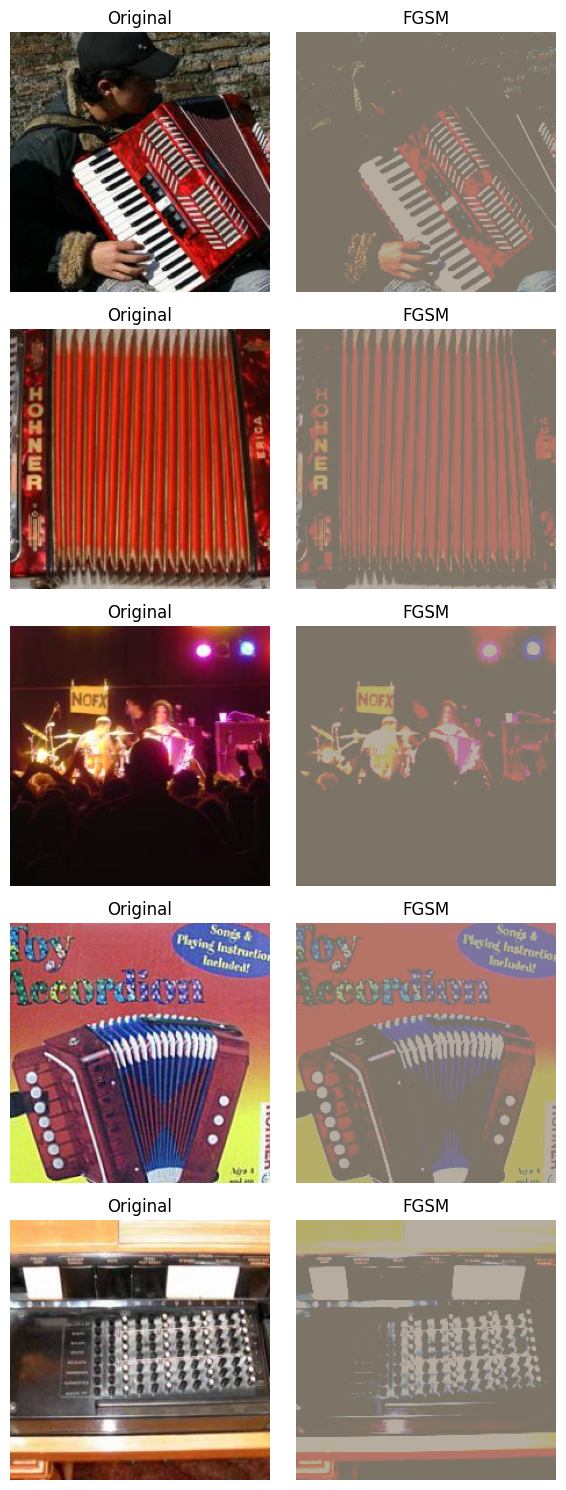


Evaluating ResNet-34 on Adversarial Test Set 1...


Evaluation complete: Top-1=26.40%, Top-5=50.60%, Time elapsed: 0.6s
FGSM Top-1: 26.40%  |  Top-5: 50.60%


In [8]:
# ============================================================
# FGSM Adversarial Attack (ε=0.02)  →  Generate Adversarial Test Set 1
# ============================================================
import torch.nn.functional as F
from pathlib import Path

# Attack parameters
epsilon = 0.02  # Perturbation size based on pixel range 0~1
adv_root = Path("./Adversarial_Test_Set_1")
adv_root.mkdir(parents=True, exist_ok=True)

# Inverse normalization for saving visualizations
inv_norm = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean_norms, std_norms)],
    std=[1/s for s in std_norms]
)

def fgsm_attack(image, gradient, eps):
    """Perform FGSM: x_adv = x + eps * sign(∇x L)"""
    sign_grad = gradient.sign()
    perturbed = image + eps * sign_grad
    return torch.clamp(perturbed, 0, 1)  # Clamp values to range 0~1

# Generate adversarial samples and save them
print("Generating FGSM adversarial samples...")
resnet34.eval()
adv_images = []
all_labels = []

for batch_idx, (imgs, targets) in enumerate(tqdm(loader, desc="FGSM", leave=False)):
    imgs, targets = imgs.to(device), targets.to(device)
    imgs.requires_grad = True
    outputs = resnet34(imgs)
    loss = F.cross_entropy(outputs, targets)
    resnet34.zero_grad()
    loss.backward()
    grad = imgs.grad.data
    # Generate adversarial images
    adv_batch = fgsm_attack(imgs.detach(), grad, epsilon)
    adv_images.append(adv_batch.cpu())
    all_labels.append(targets.cpu())

adv_images = torch.cat(adv_images)
all_labels = torch.cat(all_labels)
print(f"Number of adversarial images generated: {adv_images.size(0)}")

# ---------- Save to disk ----------
print("Saving adversarial images to disk...")
for idx in range(adv_images.size(0)):
    img = inv_norm(adv_images[idx]).clamp(0, 1)  # Inverse normalize to range 0~1 for visualization
    synset = raw_dataset.classes[raw_dataset.class_to_idx_inv[all_labels[idx].item()]] if hasattr(raw_dataset, 'class_to_idx_inv') else None
    # Without synchronized mapping, save all images in the same directory
    out_path = adv_root / f"img_{idx:04d}.png"
    torchvision.utils.save_image(img, out_path)

print("Saving completed!")

# ---------- Visualize 5 comparison examples ----------
print("Displaying examples of Original vs Adversarial images:")
num_show = 5
fig, axes = plt.subplots(num_show, 2, figsize=(6, num_show*3))
for i in range(num_show):
    orig_img = inv_norm(raw_dataset[i][0]).clamp(0,1)
    adv_img = inv_norm(adv_images[i]).clamp(0,1)
    axes[i,0].imshow(orig_img.permute(1,2,0).cpu())
    axes[i,0].set_title('Original')
    axes[i,0].axis('off')
    axes[i,1].imshow(adv_img.permute(1,2,0).cpu())
    axes[i,1].set_title('FGSM')
    axes[i,1].axis('off')
plt.tight_layout()
plt.show()

# ---------- Evaluate on adversarial dataset ----------
print("\nEvaluating ResNet-34 on Adversarial Test Set 1...")
adv_dataset = torch.utils.data.TensorDataset(adv_images, all_labels)
adv_loader = torch.utils.data.DataLoader(adv_dataset, batch_size=64, shuffle=False)
adv_top1, adv_top5, _ = evaluate(resnet34, adv_loader)
print(f"FGSM Top-1: {adv_top1:.2f}%  |  Top-5: {adv_top5:.2f}%")


Generating PGD adversarial samples …


Number of adversarial images generated: 500


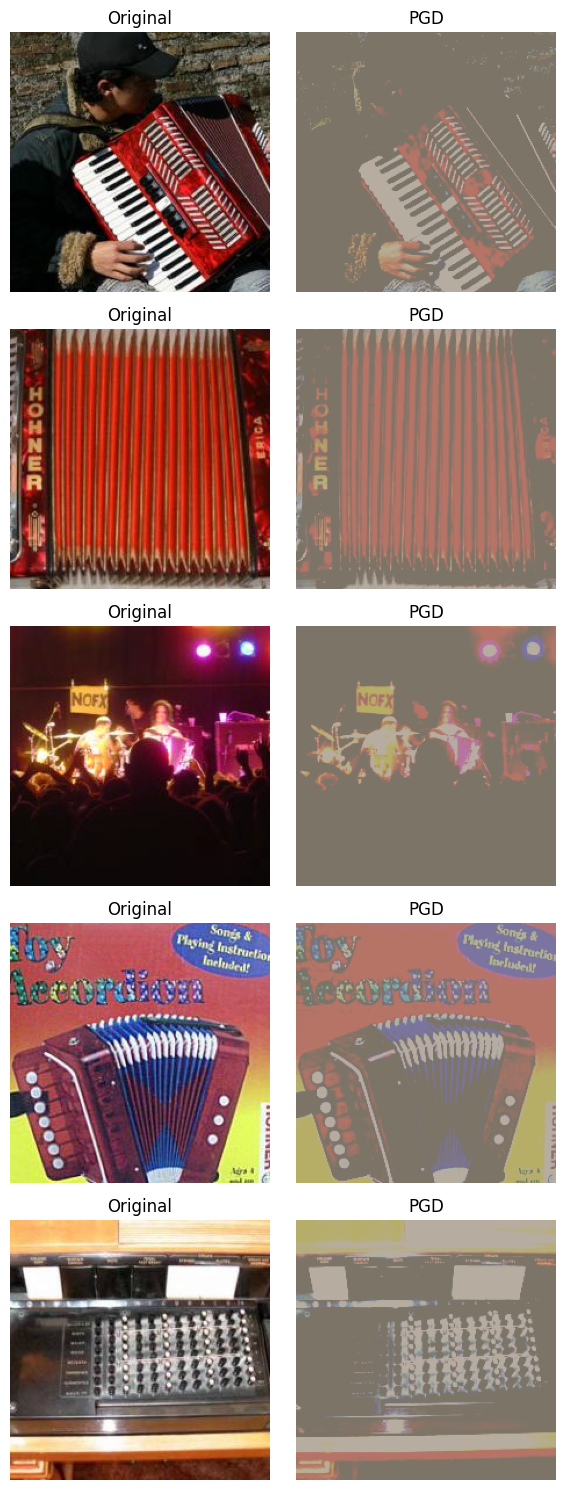

Evaluating ResNet-34 on Adversarial Test Set 2 …


Evaluation complete: Top-1=0.40%, Top-5=6.80%, Time elapsed: 0.6s
PGD Top-1: 0.40%  |  Top-5: 6.80%


In [9]:
# PGD Attack (ε=0.02, α=0.004, steps=10) to generate Adversarial Test Set 2
import torch.nn.functional as F
from pathlib import Path
from tqdm import tqdm

# Attack hyperparameters
epsilon = 0.02          # Maximum perturbation (L∞ norm)
alpha = 0.004           # Step size
steps = 10              # Number of iterations

adv2_root = Path("./Adversarial_Test_Set_2")
adv2_root.mkdir(parents=True, exist_ok=True)

def pgd_attack(model, images, labels, eps, alpha, iters):
    """
    Multi-step PGD attack (untargeted):
    Perform gradient ascent within the L∞ ball of radius ε, 
    and project back to the ε-ball & [0,1] pixel range at each step.
    """
    ori = images.data
    images = images.clone().detach().requires_grad_(True).to(device)
    for _ in range(iters):
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        grad = images.grad.data
        images = images + alpha * grad.sign()          # Take a step in the direction of the gradient
        # Project to the ε-ball
        eta = torch.clamp(images - ori, min=-eps, max=eps)
        images = torch.clamp(ori + eta, 0, 1).detach_()
        images.requires_grad_(True)
    return images.detach()

print("Generating PGD adversarial samples …")
adv2_images, adv2_labels = [], []
for imgs, targets in tqdm(loader, desc="PGD", leave=False):
    imgs, targets = imgs.to(device), targets.to(device)
    adv_batch = pgd_attack(resnet34, imgs, targets, epsilon, alpha, steps)
    adv2_images.append(adv_batch.cpu())
    adv2_labels.append(targets.cpu())

adv2_images = torch.cat(adv2_images)
adv2_labels = torch.cat(adv2_labels)
print(f"Number of adversarial images generated: {adv2_images.size(0)}")

# Save images after inverse normalization (for visualization)
for idx in range(adv2_images.size(0)):
    img = inv_norm(adv2_images[idx]).clamp(0, 1)
    torchvision.utils.save_image(img, adv2_root / f"img_{idx:04d}.png")

# Simple visualization of 5 comparison examples
num_show = 5
fig, axes = plt.subplots(num_show, 2, figsize=(6, num_show*3))
for i in range(num_show):
    orig = inv_norm(raw_dataset[i][0]).clamp(0,1)
    adv  = inv_norm(adv2_images[i]).clamp(0,1)
    axes[i,0].imshow(orig.permute(1,2,0))
    axes[i,0].set_title("Original"); axes[i,0].axis("off")
    axes[i,1].imshow(adv.permute(1,2,0))
    axes[i,1].set_title("PGD"); axes[i,1].axis("off")
plt.tight_layout(); plt.show()

print("Evaluating ResNet-34 on Adversarial Test Set 2 …")
adv2_dataset = torch.utils.data.TensorDataset(adv2_images, adv2_labels)
adv2_loader = torch.utils.data.DataLoader(adv2_dataset, batch_size=64, shuffle=False)
adv2_top1, adv2_top5, _ = evaluate(resnet34, adv2_loader)
print(f"PGD Top-1: {adv2_top1:.2f}%  |  Top-5: {adv2_top5:.2f}%")


Generating Patch‑PGD adversarial samples …


Number of adversarial images generated: 500


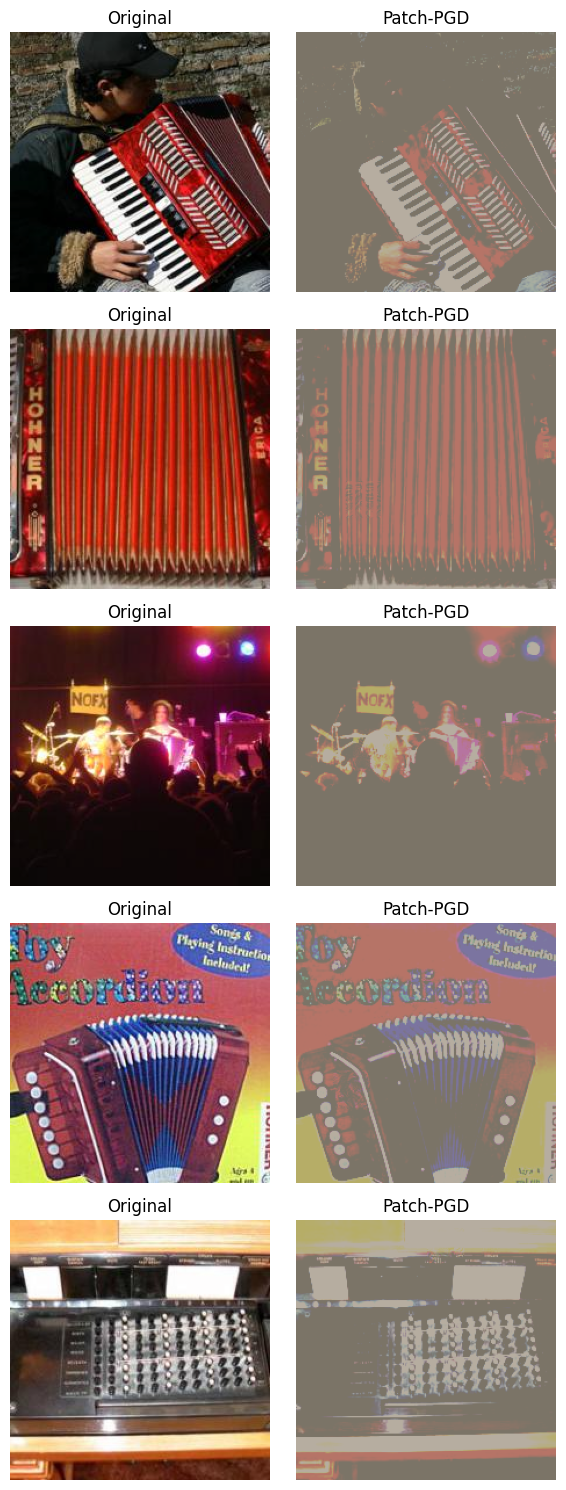


Evaluating ResNet‑34 on Adversarial Test Set 3 …


Evaluation complete: Top-1=16.40%, Top-5=39.20%, Time elapsed: 0.6s
Patch‑PGD Top‑1: 16.40%  |  Top‑5: 39.20%


In [10]:
# Patch‑PGD Attack: Perturb only a random 32×32 region (ε=0.5) to generate Adversarial Test Set 3

from pathlib import Path
import torch.nn.functional as F

patch_size = 32           # Size of the patch (32×32)
epsilon_patch = 0.5       # Allow larger perturbations
alpha_patch   = 0.05      # Step size
steps_patch   = 20        # Number of iterations

adv3_root = Path("./Adversarial_Test_Set_3")
adv3_root.mkdir(parents=True, exist_ok=True)

def patch_pgd_attack(model, images, labels, eps, alpha, iters, patch_size):
    """
    Perform PGD attack only within a random patch.
    """
    ori = images.clone().detach()
    B, C, H, W = images.size()
    # Randomly generate the top-left corner coordinates of the patch
    top  = torch.randint(0, H - patch_size + 1, (B,), device=images.device)
    left = torch.randint(0, W - patch_size + 1, (B,), device=images.device)

    # Initialize perturbation as zero
    adv = images.clone().detach().requires_grad_(True)

    for _ in range(iters):
        outputs = model(adv)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        grad = adv.grad.data

        # For each image, update only the patch region
        for i in range(B):
            t, l = top[i], left[i]
            adv.data[i, :, t:t+patch_size, l:l+patch_size] += alpha * grad[i, :, t:t+patch_size, l:l+patch_size].sign()

        # Project to the ε-ball & [0,1], but constrain only the patch
        eta = torch.clamp(adv - ori, min=-eps, max=eps)
        adv.data = torch.clamp(ori + eta, 0, 1)

        adv.grad.zero_()

    return adv.detach()

print("Generating Patch‑PGD adversarial samples …")
adv3_images, adv3_labels = [], []
for imgs, targets in tqdm(loader, desc="Patch‑PGD", leave=False):
    imgs, targets = imgs.to(device), targets.to(device)
    adv_batch = patch_pgd_attack(resnet34, imgs, targets, epsilon_patch, alpha_patch, steps_patch, patch_size)
    adv3_images.append(adv_batch.cpu())
    adv3_labels.append(targets.cpu())

adv3_images = torch.cat(adv3_images)
adv3_labels = torch.cat(adv3_labels)
print(f"Number of adversarial images generated: {adv3_images.size(0)}")

# Save adversarial images
for idx in range(adv3_images.size(0)):
    img = inv_norm(adv3_images[idx]).clamp(0, 1)
    torchvision.utils.save_image(img, adv3_root / f"img_{idx:04d}.png")

# Visualize 5 examples
num_show = 5
fig, axes = plt.subplots(num_show, 2, figsize=(6, num_show*3))
for i in range(num_show):
    orig = inv_norm(raw_dataset[i][0]).clamp(0,1)
    adv  = inv_norm(adv3_images[i]).clamp(0,1)
    axes[i,0].imshow(orig.permute(1,2,0))
    axes[i,0].set_title("Original"); axes[i,0].axis("off")
    axes[i,1].imshow(adv.permute(1,2,0))
    axes[i,1].set_title("Patch‑PGD"); axes[i,1].axis("off")
plt.tight_layout(); plt.show()

# Evaluate on Adversarial Test Set 3
print("\nEvaluating ResNet‑34 on Adversarial Test Set 3 …")
adv3_dataset = torch.utils.data.TensorDataset(adv3_images, adv3_labels)
adv3_loader  = torch.utils.data.DataLoader(adv3_dataset, batch_size=64, shuffle=False)
adv3_top1, adv3_top5, _ = evaluate(resnet34, adv3_loader)
print(f"Patch‑PGD Top‑1: {adv3_top1:.2f}%  |  Top‑5: {adv3_top5:.2f}%")


In [11]:
# Task 5: Model Transferability Test — DenseNet‑121 Accuracy on Four Datasets

import torchvision

# Load pre-trained DenseNet‑121 weights
print("Loading DenseNet‑121 …")
densenet = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device)
densenet.eval()
print("DenseNet‑121 is ready!")

# Build DataLoaders for four datasets
orig_loader = loader  # Original test set
adv1_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(adv_images, all_labels), batch_size=64, shuffle=False)
adv2_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(adv2_images, adv2_labels), batch_size=64, shuffle=False)
adv3_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(adv3_images, adv3_labels), batch_size=64, shuffle=False)

loaders = {
    "Original": orig_loader,
    "Adv_Set_1 (FGSM)": adv1_loader,
    "Adv_Set_2 (PGD)":  adv2_loader,
    "Adv_Set_3 (Patch‑PGD)": adv3_loader
}

# Evaluate and summarize results
results = {}
for name, dl in loaders.items():
    top1, top5, _ = evaluate(densenet, dl)
    results[name] = (top1, top5)
    print(f"{name:<20}  Top‑1: {top1:6.2f}%   Top‑5: {top5:6.2f}%")

# Output a clean summary table
print("\n=== DenseNet‑121 Accuracy Summary ===")
for name, (t1, t5) in results.items():
    print(f"{name:<20} | Top‑1: {t1:6.2f}% | Top‑5: {t5:6.2f}%")


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


Loading DenseNet‑121 …


100%|██████████| 30.8M/30.8M [00:00<00:00, 160MB/s]


DenseNet‑121 is ready!


Evaluation complete: Top-1=74.80%, Top-5=93.60%, Time elapsed: 1.5s
Original              Top‑1:  74.80%   Top‑5:  93.60%


Evaluation complete: Top-1=42.40%, Top-5=66.40%, Time elapsed: 1.0s
Adv_Set_1 (FGSM)      Top‑1:  42.40%   Top‑5:  66.40%


Evaluation complete: Top-1=39.20%, Top-5=64.00%, Time elapsed: 1.0s
Adv_Set_2 (PGD)       Top‑1:  39.20%   Top‑5:  64.00%


Evaluation complete: Top-1=43.00%, Top-5=67.20%, Time elapsed: 1.0s
Adv_Set_3 (Patch‑PGD)  Top‑1:  43.00%   Top‑5:  67.20%

=== DenseNet‑121 Accuracy Summary ===
Original             | Top‑1:  74.80% | Top‑5:  93.60%
Adv_Set_1 (FGSM)     | Top‑1:  42.40% | Top‑5:  66.40%
Adv_Set_2 (PGD)      | Top‑1:  39.20% | Top‑5:  64.00%
Adv_Set_3 (Patch‑PGD) | Top‑1:  43.00% | Top‑5:  67.20%


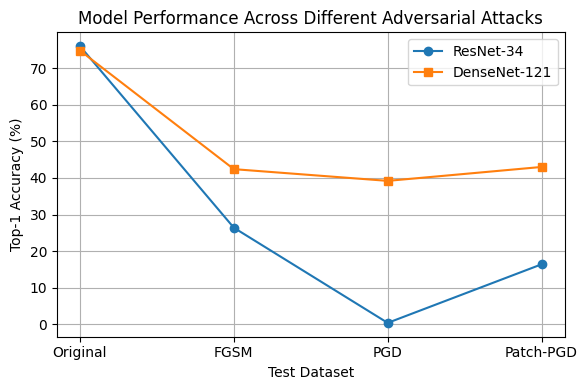

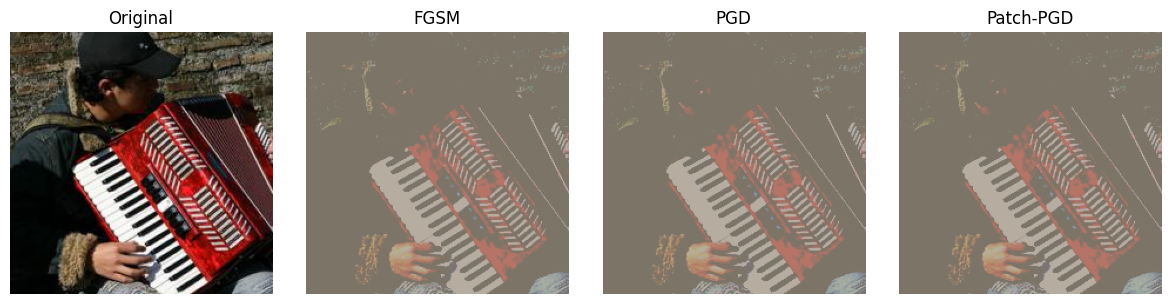

In [14]:
import matplotlib.pyplot as plt
import torchvision

# 1. Line plot for accuracy comparison
dataset_names = ["Original", "FGSM", "PGD", "Patch-PGD"]
resnet_top1 = [baseline_top1, adv_top1, adv2_top1, adv3_top1]
densenet_top1 = [results[name][0] for name in ["Original", "Adv_Set_1 (FGSM)", "Adv_Set_2 (PGD)", "Adv_Set_3 (Patch‑PGD)"]]

# Plot and save the line chart
plt.figure(figsize=(6, 4))
plt.plot(dataset_names, resnet_top1, marker='o', label='ResNet-34')
plt.plot(dataset_names, densenet_top1, marker='s', label='DenseNet-121')
plt.xlabel('Test Dataset')
plt.ylabel('Top-1 Accuracy (%)')
plt.title('Model Performance Across Different Adversarial Attacks')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('accuracy_curve.png', dpi=300)
plt.show()

# 2. Adversarial example visualization (index 0)
idx = 0
orig_img  = inv_norm(raw_dataset[idx][0]).permute(1, 2, 0).cpu()
fgsm_img  = inv_norm(adv_images[idx]).permute(1, 2, 0).cpu()
pgd_img   = inv_norm(adv2_images[idx]).permute(1, 2, 0).cpu()
patch_img = inv_norm(adv3_images[idx]).permute(1, 2, 0).cpu()


fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax, img, title in zip(axes, [orig_img, fgsm_img, pgd_img, patch_img], dataset_names):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.savefig('example_adversarial.png', dpi=300)
plt.show()